In [4]:
! pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 12.0 MB/s 


src: https://towardsai.net/p/deep-learning/house-price-predictions-using-keras

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential # Sequential Neural Network
from keras.layers import Dense
from keras.callbacks import EarlyStopping # Early Stopping Callback
from tensorflow.keras.optimizers import Adam # Optimizer
from keras_tuner.tuners import RandomSearch # HyperParameter Tuning
import warnings
warnings.filterwarnings('ignore') # To ignore warnings.

In [7]:
train = pd.read_csv('/content/drive/MyDrive/IMS COLLEGE/notebooks/datasets/house_price_pred/train.csv')
test = pd.read_csv('/content/drive/MyDrive/IMS COLLEGE/notebooks/datasets/house_price_pred/test.csv')
y = train['SalePrice'].values
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['SalePrice'],axis=1,inplace=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [8]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(data)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,FireplaceQu,1420,48.646797
5,LotFrontage,486,16.649538
6,GarageFinish,159,5.447071
7,GarageQual,159,5.447071
8,GarageCond,159,5.447071
9,GarageYrBlt,159,5.447071


In [9]:
data['BsmtFinSF1'].fillna(0, inplace=True)
data['BsmtFinSF2'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(0, inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)
data['Electrical'].fillna('FuseA',inplace = True)
data['KitchenQual'].fillna('TA',inplace=True)
data['LotFrontage'].fillna(data.groupby('1stFlrSF')['LotFrontage'].transform('mean'),inplace=True)
data['LotFrontage'].interpolate(method='linear',inplace=True)
data['MasVnrArea'].fillna(data.groupby('MasVnrType')['MasVnrArea'].transform('mean'),inplace=True)
data['MasVnrArea'].interpolate(method='linear',inplace=True)
for col in NAN_col:
    data_type = data[col].dtype
    if data_type == 'object':
        data[col].fillna('NA',inplace=True)
    else:
        data[col].fillna(data[col].mean(),inplace=True)

Adding New Features<br>
After thoroughly understanding the data, we have also created some new features by combining the given ones.

In [10]:
data['Total_Square_Feet'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF'])

data['Total_Bath'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data['Total_Porch_Area'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

data['SqFtPerRoom'] = data['GrLivArea'] / (data['TotRmsAbvGrd'] + data['FullBath'] + data['HalfBath'] + data['KitchenAbvGr'])

One Hot Encoding of the Categorical Features <br>
We would first see the distribution of features between numeric and categorical.

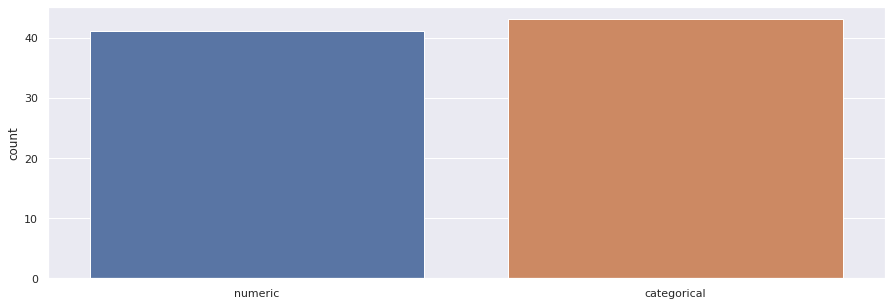

In [11]:
column_data_type = []
for col in data.columns:
    data_type = data[col].dtype
    if data[col].dtype in ['int64','float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
plt.figure(figsize=(15,5))
sns.countplot(x=column_data_type)
plt.show()


In [12]:
data = pd.get_dummies(data)


In [14]:
"""
After this operation, our original 80 features have been expanded to 314 features. 
Basically, each label of a categorical feature turns into a new feature with 
binary values(1 for present and 0 for not present). 
Now we would split our combined data into training and 
testing data to do some exploratory analysis on our training data."""

train = data[:1460].copy()
test = data[1460:].copy()
train['SalePrice'] = y

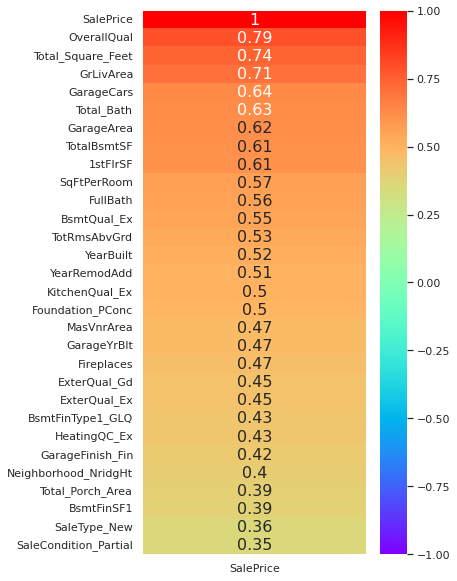

In [15]:
"""Exploratory Data Analysis & Outliers Detection
We would first extract the top-features from our training dataset that have the 
highest correlation with the Sale Price.
"""
top_features = train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [16]:
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

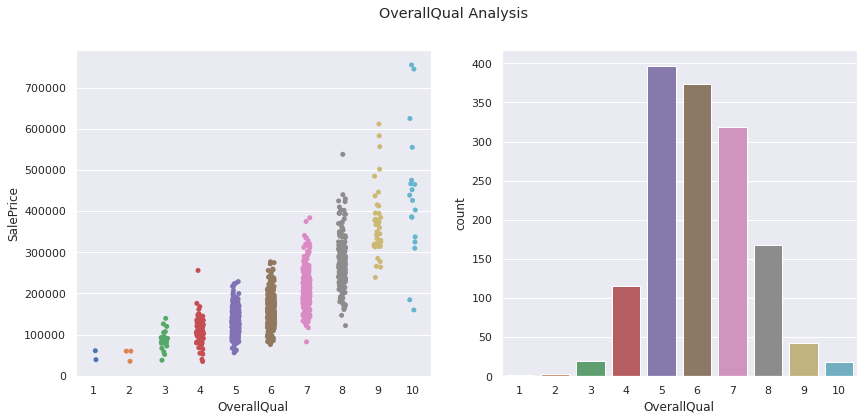

In [17]:
plot_data('OverallQual',True)


In [18]:
# We see there are two outliers with 10 overall quality and sale price less than 200000.
train = train.drop(train[(train['OverallQual'] == 10) & (train['SalePrice'] < 200000)].index)

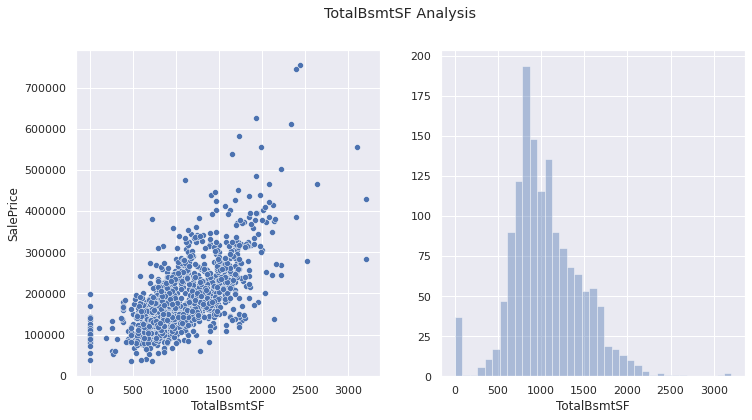

In [19]:
plot_data('TotalBsmtSF')


In [20]:
"""
Here as well we see 1 clear outlier that has TotalBsmtSF more than 3000 but sale price less than 300000.
"""
train = train.drop(train[(train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 400000)].index)

In [21]:
train.reset_index() # To reset the index


,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,0,0,1,0,0,0,0,1,0,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,1,0,0,0,0,1,0,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,0,0,1,0,0,0,0,1,0,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,0,0,1,1,0,0,0,0,0,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1455,1456,60,62.0,7917,6,5,1999,2000,0.0,...,0,0,1,0,0,0,0,1,0,175000
1453,1456,1457,20,85.0,13175,6,6,1978,1988,119.0,...,0,0,1,0,0,0,0,1,0,210000
1454,1457,1458,70,66.0,9042,7,9,1941,2006,0.0,...,0,0,1,0,0,0,0,1,0,266500
1455,1458,1459,20,68.0,9717,5,6,1950,1996,0.0,...,0,0,1,0,0,0,0,1,0,142125


In [22]:
# Now that we have taken care of the top features of our dataset we would further remove outliers using the Isolation Forest Algorithm. We use this algorithm since it would be difficult to go through all the features and eliminate the outliers manually but it was important to do it manually for the features that have a high correlation with the SalePrice.

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 24
Number of rows without outliers: 1433


In [23]:
# We would finally use Standard Scalar from sklearn to scale our data.

X = train.copy()
X.drop(['SalePrice'],axis=1,inplace=True) # Dropped the y feature
y = train['SalePrice'].values


In [27]:
"""
MODELLING
We would use Random Search Algorithm from Keras for hyper-parameter tuning of the model.
"""
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
 
tuner.search(X[1100:],y[1100:],batch_size=128,epochs=200,validation_data=(X[:1100],y[:1100]))
model = tuner.get_best_models(1)[0]

Trial 2 Complete [00h 01m 57s]
val_mse: 1608602965.3333333

Best val_mse So Far: 1260260650.6666667
Total elapsed time: 00h 03m 23s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
5                 |9                 |layers
160               |96                |units_0
320               |288               |units_1
0.001             |0.01              |learning_rate
384               |32                |units_2
160               |32                |units_3
352               |32                |units_4
416               |32                |units_5
64                |32                |units_6
320               |32                |units_7
128               |32                |units_8
480               |None              |units_9

Epoch 1/200
3/3 [==============================] - 1s 131ms/step - loss: 38979293184.0000 - mse: 38979293184.0000 - val_loss: 38671712256.0000 - val_mse: 38671712256.0000
Epoch 2/200
3/3 [==============================] - 0s 64ms/

KeyboardInterrupt: ignored

In [28]:
"""
The above code is used for tuning the parameters so that we can generate an 
effective model for our dataset. After running the above code, 
I got the hyper-parameters that would give me the most effective results for my dataset. 
I have written a separate function to show this model since running the above code would take a lot of time.
"""

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 320)               100800    
                                                                 
 dense_7 (Dense)             (None, 384)               123264    
                                                                 
 dense_8 (Dense)             (None, 352)               135520    
                                                                 
 dense_9 (Dense)             (None, 448)               158144    
                                                                 
 dense_10 (Dense)            (None, 160)               71840     
                                                                 
 dense_11 (Dense)            (None, 160)               25760     
                                                                 
 dense_12 (Dense)            (None, 32)               

Epoch 1/10
11/11 [==============================] - 0s 18ms/step - loss: 37567266816.0000 - val_loss: 33523884032.0000
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 34637152256.0000 - val_loss: 29118953472.0000
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 28328046592.0000 - val_loss: 20173467648.0000
Epoch 4/10
11/11 [==============================] - 0s 19ms/step - loss: 18078771200.0000 - val_loss: 8487518208.0000
Epoch 5/10
11/11 [==============================] - 0s 18ms/step - loss: 12284406784.0000 - val_loss: 5453563904.0000
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 11423592448.0000 - val_loss: 5249288192.0000
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 10170098688.0000 - val_loss: 5566477824.0000
Epoch 8/10
11/11 [==============================] - 0s 18ms/step - loss: 9004337152.0000 - val_loss: 4426158592.0000
Epoch 9/10
11/11 [==============================] - 0s

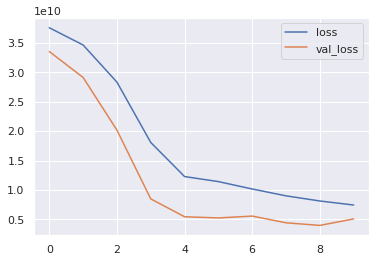

In [30]:
"""We would be using early stopping callback and would use 1/10th of 
the training data as validation to estimate the optimum number of epochs 
that would prevent overfitting
"""
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=10, callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

Epoch 1/10
12/12 [==============================] - 1s 23ms/step - loss: 39095615488.0000
Epoch 2/10
12/12 [==============================] - 0s 19ms/step - loss: 38290534400.0000
Epoch 3/10
12/12 [==============================] - 0s 18ms/step - loss: 36248293376.0000
Epoch 4/10
12/12 [==============================] - 0s 22ms/step - loss: 31384604672.0000
Epoch 5/10
12/12 [==============================] - 0s 18ms/step - loss: 21968652288.0000
Epoch 6/10
12/12 [==============================] - 0s 17ms/step - loss: 11871490048.0000
Epoch 7/10
12/12 [==============================] - 0s 17ms/step - loss: 11805002752.0000
Epoch 8/10
12/12 [==============================] - 0s 16ms/step - loss: 10213984256.0000
Epoch 9/10
12/12 [==============================] - 0s 17ms/step - loss: 8711362560.0000
Epoch 10/10
12/12 [==============================] - 0s 15ms/step - loss: 7755915776.0000


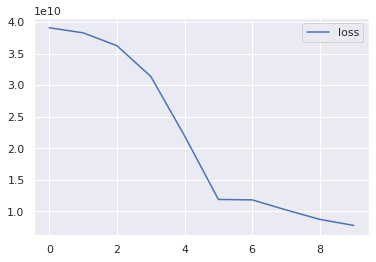

In [32]:
"""
This code shows an early stop at around 160 and since we only used 90% 
of our training data, therefore we would add 10 to it as a rough estimate and 
take the number of epochs as 170. Thus we would again reset our model and 
train our model on the complete training dataset.
"""
model = create_model() # Resetting the model.
history = model.fit(x=X,y=y,
          batch_size=128,epochs=10)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [37]:
"""
Prediction and Evaluation
We would now run our model against the testing dataset. 
But before that we need to scale the testing data in the same way as we did 
for the training data and for that, we would again make use of the 
StandardScaler function from Sklearn.
"""
scale=StandardScaler() 
X_test = scale.fit_transform(X=test) # Scaling the testing data.
result = model.predict(X_test) # Prediction using model
result = pd.DataFrame(result,columns=['SalePrice']) # Dataframe
result['Id'] = test['Id'] # Adding ID to our result dataframe.
result = result[['Id','SalePrice']]
result.head()

,Id,SalePrice
0,1461,85.116203
1,1462,203.123199
2,1463,77.942360
3,1464,81.869171
4,1465,89.220276
